In [5]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [3]:
seed = 1
np.random.seed(seed)

In [4]:
ROOT = Path.cwd().parent/'ML'


# DATA 

In [5]:
ROOT = Path.cwd().parent/'ML'
#샘플데이터
SAMPLE = ROOT/'sample_submission.csv'
TRAIN = ROOT/'train_x.csv'
TARGET = ROOT/'train_y.csv'
TEST = ROOT/'test_x.csv'
RESULT = ROOT/'test_y.csv'

ID_COLS = ['series_id', 'measurement_num']

x_cols = {
    'series_id' : np.uint32,
    'measurement_num': np.uint32,
    'x' : np.float32,
    'y' : np.float32,
    'z' : np.float32
}

y_cols = {
    'series_id' : np.uint32,
    'activity' : str
}


In [6]:
x_trn = pd.read_csv(TRAIN, usecols = x_cols.keys(), dtype=x_cols)
x_tst = pd.read_csv(TEST, usecols = x_cols.keys(), dtype=x_cols)
y_trn = pd.read_csv(TARGET, usecols = y_cols.keys(), dtype=y_cols)
y_tst = pd.read_csv(RESULT, usecols = y_cols.keys(), dtype=y_cols)

In [7]:
raw_arr =np.load(ROOT/'feat.npy').transpose(0, 2,1)
print(raw_arr.shape[1])

9


In [8]:
print(x_trn)

        series_id  measurement_num          x         y         z
0               0                0  -3.984212  1.166823  8.641599
1               0                1  -3.978943  0.965602  8.861025
2               0                2  -3.679507  0.942606  8.753708
3               0                3  -3.181248  1.006804  7.352831
4               0                4  -1.938474  0.259415  3.109001
...           ...              ...        ...       ...       ...
299995       9999               25  -8.087312 -1.065687 -2.028808
299996       9999               26  -7.934237 -1.677310 -1.179753
299997       9999               27  -8.763372 -0.735752 -1.184813
299998       9999               28 -11.866045 -1.526172 -1.930170
299999       9999               29 -12.879398 -3.972492 -0.904189

[300000 rows x 5 columns]


# Pytorch Wrapper

In [9]:
def create_datasets(X, y, test_size=0.2, dropcols = ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size = 0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (y_train, y_valid)]

    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    
    return train_ds, valid_ds, enc

def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
        X_grouped = np.row_stack([
            group.drop(columns=drop_cols).values[None]
            for _, group in data.groupby(group_col)
        ])
        
        return X_grouped

def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')
    ])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)
    
def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    
    return train_dl, valid_dl

def accuracy(output, target):
    return(output.argmax(dim=1) == target).float().mean().item()

# Model

In [10]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

In [11]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [12]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [13]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 5, 2, 3, drop=drop),
            SepConv1d(    32,  64, 5, 4, 2, drop=drop),
            SepConv1d(    64, 128, 5, 4, 2, drop=drop),
            SepConv1d(   128, 256, 5, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
#         self.fft = nn.Sequential(
#             SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
#             SepConv1d(    32,  64, 8, 2, 4, drop=drop),
#             SepConv1d(    64, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 128, 8, 4, 4, drop=drop),
#             SepConv1d(   128, 256, 8, 2, 3),
#             Flatten(),
#             nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
#             nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        #fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out], dim=1)
        out = self.out(t_in)
        return out

In [14]:
print('데이터셋 준비')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['activity'])
trn_sz = len(trn_ds)
print(len(trn_ds))

데이터셋 준비
9000


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=cpu_count())
print(len(trn_dl))


Creating data loaders with batch size: 128
71


In [19]:
lr = 0.0005
n_epochs = 100
iterations_per_epoch = len(trn_dl)
num_classes = 9
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(30, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        #print(x_raw)
        out = model(x_raw)
        #y_batch = np.long(y_batch)
        loss = criterion(out, y_batch.long())
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.2774. Acc.: 53.00%
Epoch 1 best model saved with accuracy: 53.00%
Epoch:   2. Loss: 0.7009. Acc.: 47.00%
Epoch:   4. Loss: 0.6891. Acc.: 82.00%
Epoch 4 best model saved with accuracy: 82.00%
Epoch 5 best model saved with accuracy: 90.90%
Epoch 6 best model saved with accuracy: 92.70%
Epoch 7 best model saved with accuracy: 94.90%
Epoch:   8. Loss: 0.2107. Acc.: 96.00%
Epoch 8 best model saved with accuracy: 96.00%
Epoch 10 best model saved with accuracy: 96.10%
Epoch 11 best model saved with accuracy: 96.30%
Epoch 12 best model saved with accuracy: 96.70%
Epoch 13 best model saved with accuracy: 96.80%
Epoch 14 best model saved with accuracy: 97.10%
Epoch:  16. Loss: 0.1325. Acc.: 97.50%
Epoch 16 best model saved with accuracy: 97.50%
Epoch 18 best model saved with accuracy: 97.70%
Epoch 21 best model saved with accuracy: 98.00%
Epoch 23 best model saved with accuracy: 98.40%
Epoch 24 best model saved with accuracy: 98.50%
Epoch 28 best model sa

In [20]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


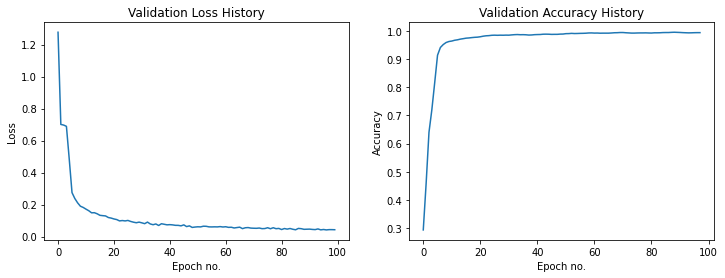

In [21]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [22]:
tst_dl = DataLoader(create_test_dataset(x_tst), batch_size=64, shuffle=False)
test = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
# for x_raw, _ in tst_dl:
#     batches = [t.to(device) for t in x_raw]
#     out = model(*batches)
#     y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
#     test_results.extend(y_hat.tolist())
    
for batch, _ in tst_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

data = {
    "series_id" : [n for n in range(len(x_tst['series_id'])// 30)],
    "activity" : ["walk" for i in range(len(x_tst['series_id'])// 30)]
}

sample = pd.DataFrame(data, columns = ["series_id", "activity"], index = None)
sample.to_csv('sample_submission.csv', index=None)

submit = pd.read_csv(SAMPLE)
submit['activity'] = enc.inverse_transform(test)
submit.to_csv('submit.csv', index=None)

In [37]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
answer = 0
guesses = []
labels = []

for i in range(len(submit['activity'])):
    if submit['activity'][i] == "fall":
        guesses.append(1)
    else:
        guesses.append(0)
    if y_tst['activity'][i] == "fall":
        labels.append(1)
    else:
        labels.append(0)

print(confusion_matrix(labels, guesses))
print(accuracy_score(labels, guesses))
print(recall_score(labels, guesses))
print(precision_score(labels, guesses))
print(f1_score(labels, guesses))

for i in range(len(submit['activity'])):
    if submit['activity'][i] == y_tst['activity'][i]:
        answer = answer + 1

print("Test Accuracy : ", answer / len(submit['activity']) *100, "%")

[[1979   21]
 [  11 1989]]
0.992
0.9945
0.9895522388059701
0.9920199501246882
Test Accuracy :  99.2 %
